In [1]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt, animation as animation, ticker as mticker
from matplotlib.pyplot import cm
import matplotlib as mpl
plt.rcParams.update({'font.size': 10})
from matplotlib.patches import Ellipse, Circle
import matplotlib.transforms as transforms
import pandas as pd
import scipy as sp
import astropy as ap
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
from scipy.interpolate import splprep, splev
from scipy.stats import gaussian_kde


from fireworks.particles import Particles
import fireworks.nbodylib.nunits as NU
import fireworks.nbodylib.potentials as fnp
import fireworks.nbodylib.dynamics as fnd
import fireworks.nbodylib.integrators as fni

In [2]:
def cartesian2spherical(rectangular_coordinates: list, out_type:str='rad'):
    """
    Converts Cartesian coordinates to spherical coordinates.
    Parameters
    ----------
    rectangular_coordinates : list
        A list of coordinates of the point in Cartesian space.
    out_type : str, optional
        Whether the theta and phi arguments in output should be in degree or
        radian units. The default is 'rad'.
    Returns
    -------
    rho, theta, phi
    """
    # initialize the coordinates
    x, y, z = rectangular_coordinates
    # calculate rho
    rho = np.sqrt(x**2 + y**2 + z**2)
    # calculate theta
    theta = np.arccos(z / rho)
    # calculate phi, the reason for using arctan2 is that the range of theta
    # parameter is -180 < theta < 180.
    phi = np.arctan2(y, x)
    if out_type == 'deg':
        theta, phi = np.degrees([theta, phi])
    return rho, theta, phi

In [3]:
def cyl_coord(pos, vel):
    rho = np.sqrt(pos[..., 0]**2 + pos[..., 1]**2)
    phi = np.arctan2(pos[..., 1], pos[..., 0])
    phi = np.where(phi < 0, phi + 2*np.pi, phi)

    vel_r = vel[...,0]*np.cos(phi) + vel[...,1]*np.sin(phi)
    vel_phi = -vel[...,0]*np.sin(phi) + vel[...,1]*np.cos(phi)
    vel_z = vel[...,2]
    
    return rho, phi, vel_r, vel_phi, vel_z


In [4]:
#single run 
N = 1000
initial_position = 10    #pos del 
M_G = 1e3    # mass of the galaxy
e=0.0
t=0.01
semi_major_axis = initial_position/(1-e)
data = np.load(f'Orbit/Galactic_FoR/{N}_InitialPos_{initial_position}_e_{e}_t_{t}.npy')
position = data[:, :, :3]
velocity = data[:, :, 3:6]
mass = data[:, :, 6]
energy = data[:, 0, 7]
potential_energy = data[:, :, 8]

# # data from mmultiple run 
# N = 1000
# initial_position = 30    #pos del 
# M_G = 1e3    # mass of the galaxy
# e=0.9
# t=0.01
# semi_major_axis = np.sqrt( initial_position/(1-e**2)  )
# data = np.load('Orbit/Galactic_FoR/Simulations_multiple_orbits/sim_e05_e09_ip20.npy')
# print(data.shape)
# data = data[1, :, :, :]
# position = data[:, :, :3]
# velocity = data[:, :, 3:6]
# mass = np.ones_like(position)[:, :, 0]


# Tidal radius and iterative calculation of the center of mass 

In [20]:
def flag_cluster(position: npt.NDArray[np.float64], velocity: npt.NDArray[np.float64], mass: npt.NDArray[np.float64], N: int, M_G: float):
    
    """
    Function to find the stars that are bound to the cluster. Create a flag array with the same length as the number of stars
    in the cluster. The flag array is set to True for the stars that are bound to the cluster and False for the stars that are
    unbound. The function returns the flag array, the center of mass of the cluster and the tidal radius of the cluster.

    Parameters
    ----------
    position : npt.NDArray[np.float64]
        Array with the positions of the stars at each snapshot

    velocity : npt.NDArray[np.float64]
        Array with the velocities of the stars at each snapshot

    mass : npt.NDArray[np.float64]
        Array with the mass of the stars at each snapshot

    N : int
        Number of stars in the cluster

    M_G : float
        Mass of the galaxy
    """

    flag_history = []
    com_history = []
    vel_com_history = []
    rt_history = []

    flag = np.ones(N, dtype=bool)
    for snapshot in range(len(position)):
        pos_snap, vel_snap = position[snapshot], velocity[snapshot]

        current_flag = np.zeros(N, dtype=bool)

        while not np.array_equal(flag, current_flag):
            current_flag = flag.copy()

            # Calculate center of mass
            if np.any(flag):
                pos_com_snap = np.average(pos_snap[flag], axis=0, weights=mass[snapshot][flag])
                vel_com_snap = np.average(vel_snap[flag], axis=0, weights=mass[snapshot][flag])
            else:
                pos_com_snap = np.zeros_like(pos_snap[0])
                vel_com_snap = np.zeros_like(vel_snap[0])

            # Calculate distances to the center of mass
            distances_to_com = np.sqrt(np.sum((pos_snap - pos_com_snap)**2, axis=1))

            # Calculate tidal radius
            r_t = np.linalg.norm(pos_com_snap) * (np.sum(mass[snapshot][flag]) / M_G) ** (1 / 3)

            # Update flag based on tidal radius
            flag = distances_to_com < 0.1*r_t

        flag_history.append(flag)
        com_history.append(pos_com_snap)
        rt_history.append(r_t)
        vel_com_history.append(vel_com_snap)

    return flag_history, com_history, rt_history, vel_com_history


In [21]:
tidal2_history = []
flag_history = []
com_history = []
vel_com_history = []
flag = np.ones(N, dtype=bool)
for snapshot in tqdm(range(len(position))):
    current_flag = np.zeros(N, dtype=bool)   #this condition is used to enter the while loop
    k = 0
    while flag.sum() - current_flag.sum() != 0: 
        if k>100:
            break
        current_flag = flag.copy()
        pos_snap, vel_snap = position[snapshot], velocity[snapshot]
        pos_snap_flag, vel_snap_flag = position[snapshot][flag], velocity[snapshot][flag]
        pos_com_snap, vel_com_snap = np.mean(pos_snap_flag, axis=0), np.mean(vel_snap_flag, axis=0)
        
        pos_FoR = pos_snap - pos_com_snap
        vel_FoR = vel_snap - vel_com_snap
        
        r_t = np.linalg.norm(pos_com_snap) * (np.sum(mass[snapshot][flag])/M_G)**(1/3)
        flag = (np.linalg.norm(pos_FoR, axis=1) < 2*r_t) #in of the Cluster
        k+=1

    flag_history.append(flag)
    com_history.append(pos_com_snap)
    vel_com_history.append(vel_com_snap)
    tidal2_history.append(r_t)

  0%|          | 0/1258 [00:00<?, ?it/s]

## Some plots and gif

### Distance between true CoM and iterative CoM in tidal radius

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.linalg.norm(np.array(com_history) - position[:].mean(axis=1), axis=1))
ax.set_xlabel('Time')
ax.set_ylabel(r'$\Delta (r_{CoM} - r_{tidalCoM})$')

### Tidal Center of Mass gif

In [ ]:
### downsampling
m = 15

pos_array_plot = position.copy() #the copy is useful to not overwrite pos_array (otherwise you would need to rerun the integration, we don't want that)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams['axes.titlesize'] = '20'
plt.rcParams['axes.titlepad'] = '17'
plt.rcParams['axes.labelsize'] = '24'
plt.rcParams['legend.fontsize'] = '20'
plt.rcParams['axes.labelpad'] = '12'
plt.rcParams['axes.titleweight'] = '600'
plt.rcParams['axes.labelweight'] = '500'
plt.rcParams['xtick.labelsize'] = '20'
plt.rcParams['ytick.labelsize'] = '20'
plt.rcParams['xtick.major.size'] = '10'
plt.rcParams['ytick.major.size'] = '10'
plt.rcParams['ytick.minor.size'] = '4'

# Calculate the number of extra frames to add at the beginning and the end
pause_duration = 5  # pause duration in seconds start
pause_duration_end = 1  # pause duration in seconds end
frame_rate = 15  # frame rate of the animation
extra_frames = pause_duration * frame_rate
extra_frames_end = pause_duration_end * frame_rate

# Create an array of frame indices
frames = np.concatenate([
    np.full(int(extra_frames), 0),  # initial frame (pause
    np.arange(0, len(pos_array_plot[:])-1, m),  # original frames
    np.full(int(extra_frames_end), len(pos_array_plot[:])-2)  # extra frames at the end
])

snapshot = 0
pos_snap = position[snapshot] - com_history[snapshot]
flag = flag_history[snapshot]
ax.scatter(pos_snap[flag, 0], pos_snap[flag, 1], pos_snap[flag, 2], label=r'$r < 2r_{t}$', s=1, alpha=0.5, zorder=-1)
ax.scatter(pos_snap[~flag, 0], pos_snap[~flag, 1], pos_snap[~flag, 2], label=r'$r> 2r_{t}$', s=1, alpha=0.5, zorder=-1)
ax.scatter(com_history[snapshot][0] - com_history[snapshot][0], com_history[snapshot][1]-com_history[snapshot][1], com_history[snapshot][2]-com_history[snapshot][2], s=15, label='iterative CoM', zorder=1)
ax.scatter(position[snapshot].mean(axis=0)[0]- com_history[snapshot][0], position[snapshot].mean(axis=0)[1]- com_history[snapshot][1], position[snapshot].mean(axis=0)[2]- com_history[snapshot][2], s=15, label='true CoM', zorder=1)
ax.set_xlim(-initial_position, initial_position)
ax.set_ylim(-initial_position, initial_position)
ax.set_zlim(-initial_position, initial_position)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend('upper left')


def update_pos(frame): 
    ax.clear()
    
    pos_snap = position[frame] - com_history[frame]
    flag = flag_history[frame]
    ax.scatter(pos_snap[flag, 0], pos_snap[flag, 1], pos_snap[flag, 2], label=r'$r < 2r_{t}$', s=1, alpha=0.5, zorder=-1)
    ax.scatter(pos_snap[~flag, 0], pos_snap[~flag, 1], pos_snap[~flag, 2], label=r'$r> 2r_{t}$', s=1, alpha=0.5, zorder=-1)
    ax.scatter(com_history[frame][0] - com_history[frame][0], com_history[frame][1]-com_history[frame][1], com_history[frame][2]-com_history[frame][2], s=15, label='iterative CoM', zorder=1)
    ax.scatter(position[frame].mean(axis=0)[0]- com_history[frame][0], position[frame].mean(axis=0)[1]- com_history[frame][1], position[frame].mean(axis=0)[2]- com_history[frame][2], s=15, label='true CoM', zorder=1)

    
    ax.set_xlim(-initial_position, initial_position)
    ax.set_ylim(-initial_position, initial_position)
    ax.set_zlim(-initial_position, initial_position)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend('upper left')
    ax.set_title(f'Tidal distruption of Plummer spehere, recursive tidal radius approach, \n {N} stars, initial position:{initial_position}, FoR recursive tidal CoM')
    ax.legend(loc='upper left')
    
    # fig.suptitle(f'Tidal distruption of Plummer spehere, recursive tidal radius approach', 
    #              fontsize=24, fontweight='600')

print(f"Starting Position Animation: {N}_InitialPos_{initial_position}.gif ")

gif_pos = animation.FuncAnimation(fig=fig, func=update_pos, frames=frames, interval=10)
gif_pos.save(f"./gif/Cluster_FoR_recursive_tidalCoM/{N}_InitialPos_{initial_position}.gif", writer="pillow")

print(f"Position Animation Saved: {N}_InitialPos_{initial_position}.gif")

# Analysis considering all the stars not just the one in the tidal radius [could be cancelled]

### %_mass_radius
For N=5000 and initial_position=10 before T=50 it is possible to appriciate the negative heat capacity   

In [ ]:
position_comFoR = np.zeros_like(position)
for i in range(len(position)):
    position_comFoR[i] = position[i] - np.array(com_history[i])

tenperc_mass_radius = []
half_mass_radius = []
ninethyperc_mass_radius = []

for i in range(int(len(position_comFoR))):
    current_radius = np.linalg.norm(position_comFoR[i], axis=1)
    sorted_radius = sorted(current_radius)
    tenperc_mass_radius.append(sorted_radius[int(N/10)])
    half_mass_radius.append(sorted_radius[int(N/2)])
    ninethyperc_mass_radius.append(sorted_radius[int(9*N/10)])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.plot(tenperc_mass_radius, label='10% mass radius')
ax.plot(half_mass_radius, label='half mass radius')
ax.plot(ninethyperc_mass_radius, label='90% mass radius')
ax.axvline(x=50, linestyle='--', c='r', linewidth=1, label='T=50')

ax.legend()
ax.grid(linestyle='dotted')
ax.set_xlabel('Time [Henon unit]')
ax.set_ylabel('Radius [Henon unit]') 
# ax.set_xlim((0, 60))
# ax.set_ylim((0, 2))

### Density profile 

In [ ]:
n_bins=10
time = 2
pos_snapshot = position_comFoR[time][flag_history[time]]
radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
counts, bin_edges = np.histogram(radius_snapshot, bins=n_bins)
Vol_shell = 4/3 *np.pi* (bin_edges[1:]**3 - bin_edges[:-1]**3)
density = counts / Vol_shell
radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1])

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot()
ax.plot(radius_shell, density)
ax.set_xlabel(r'$R_{shell}$ [Henon units]')
ax.set_ylabel(r'$\rho [\frac{Mass}{R_{shell}}]$ ')
ax.set_title(f'Time: {time}')

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
time_to_plot = [0, 1, 10, 50, 100, 150, 300]
color = cm.rainbow(np.linspace(0, 1, len(time_to_plot)))

for k, c in enumerate(color):
    time = time_to_plot[k]
    pos_snapshot = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=10)
    Vol_shell = 4/3 *np.pi* (bin_edges[1:]**3 - bin_edges[:-1]**3)
    density = counts / Vol_shell
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.plot(radius_shell, density, color=c, label=f'Time:{time}', linewidth=2)
    ax.set_xlabel(r'$R_{shell}$ [Henon units]')
    ax.set_ylabel(r'$\rho [\frac{Mass}{R_{shell}}]$ ')
    ax.set_xlim(0, 2)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_title(f'Density across time')

### Kinematics 

#### Bin the radius into shell, for each shell count the velocioty dispersion

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
for k, time in enumerate([0, 1, 2, 5, 7, 10, 25, 50]):
    pos_snapshot = position_comFoR[time]
    radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=10)
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1]) #needed to plot
    
    bins_index = np.digitize(radius_snapshot, bins=bin_edges) #return the index of the bin for each radius
    
    vel_snapshot = velocity_comFoR[time]
    vel_modul_snapshot = np.linalg.norm(vel_snapshot, axis=1)
    
    vel_modul_snaphost_binned = [vel_modul_snapshot[bins_index==i].tolist() for i in range(1, len(bin_edges)) ] #binning the velocity as the radius
    
    velocity_dispersion = []
    for i in range(len(bin_edges)-1):
        velocity_dispersion.append(np.array(vel_modul_snaphost_binned[i]).std())
    
    ax.plot(radius_shell, np.array(velocity_dispersion)-5*k, label=f'Time: {time}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Velocity dispersion in the Shell')
    ax.legend()

#### Instead of shell uses sphere (cumulative of the shell)

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
for k, time in enumerate([0, 1, 2, 5, 7, 10, 25, 50]):
    pos_snapshot = position_comFoR[time]
    radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=5)
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1]) #needed to plot
    
    bins_index = np.digitize(radius_snapshot, bins=bin_edges) #return the index of the bin for each radius
    
    vel_snapshot = velocity_comFoR[time]
    vel_modul_snapshot = np.linalg.norm(vel_snapshot, axis=1)
    
    comulative_vel_modul_snaphost_binned = [vel_modul_snapshot[bins_index<=i].tolist() for i in range(1, len(bin_edges)) ] #binning the velocity as the radius
    
    comulative_velocity_dispersion = []
    for i in range(len(bin_edges)-1):
        comulative_velocity_dispersion.append(np.array(comulative_vel_modul_snaphost_binned[i]).std())
    
    ax.plot(radius_shell, np.array(comulative_velocity_dispersion)-2*k, label=f'Time: {time}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Velocity dispersion in the Sphere')
    ax.legend()

# Analysis considering only the stars inside the tidal radius

### %_mass_radius

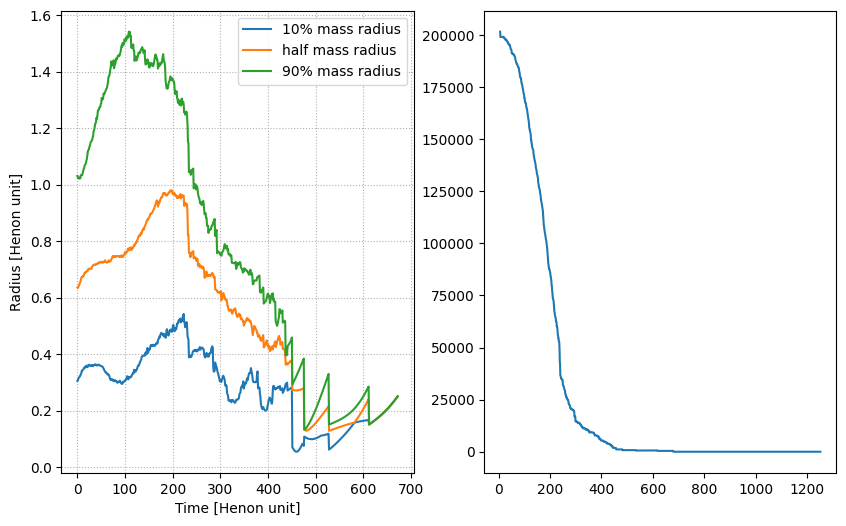

In [23]:
position_comFoR = np.zeros_like(position)
for i in range(len(position)):
    position_comFoR[i] = position[i] - np.array(com_history[i])


tenperc_mass_radius = []
half_mass_radius = []
ninethyperc_mass_radius = []
virial_condition = []

for time in range( 6, int(len(position_comFoR))-6, 1):
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    N_flagged = len(position_comFoR_flagged)
    current_radius = np.linalg.norm(position_comFoR[time], axis=1)
    sorted_radius = sorted(current_radius)
    tenperc_mass_radius.append(sorted_radius[int(N_flagged/10)])
    half_mass_radius.append(sorted_radius[int(N_flagged/2)])
    ninethyperc_mass_radius.append(sorted_radius[int(9*N_flagged/10)])
    # virial_condition.append(2*np.sum(0.5* np.linalg.norm(velocity[time][flag_history[time]], axis=1)**2)  - np.sum(potential_energy[time][flag_history[time]] + M_G/np.linalg.norm(position[time][flag_history[time]], axis=1)  ))
    mean_kin = 0
    mean_pot = 0
    for t in range(time-5, time+5):
        mean_kin += np.sum(0.5* np.linalg.norm(velocity[time][flag_history[time]], axis=1)**2)
        mean_pot += np.sum(potential_energy[time][flag_history[time]] + M_G/np.linalg.norm(position[time][flag_history[time]], axis=1))
    mean_kin = mean_kin/10
    mean_pot = mean_pot/10
    virial_condition.append(2*mean_kin + mean_pot)

    
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(tenperc_mass_radius, label='10% mass radius')
ax.plot(half_mass_radius, label='half mass radius')
ax.plot(ninethyperc_mass_radius, label='90% mass radius')

ax.legend()
ax.grid(linestyle='dotted')
ax.set_xlabel('Time [Henon unit]')
ax.set_ylabel('Radius [Henon unit]') 


ax = fig.add_subplot(1, 2, 2)
ax.plot(range( 6, int(len(position_comFoR))-6, 1), virial_condition)
# ax.set_xlim((0, 60))
# ax.set_ylim((0, 2))

### Density profile n_bins is the number of shell considered

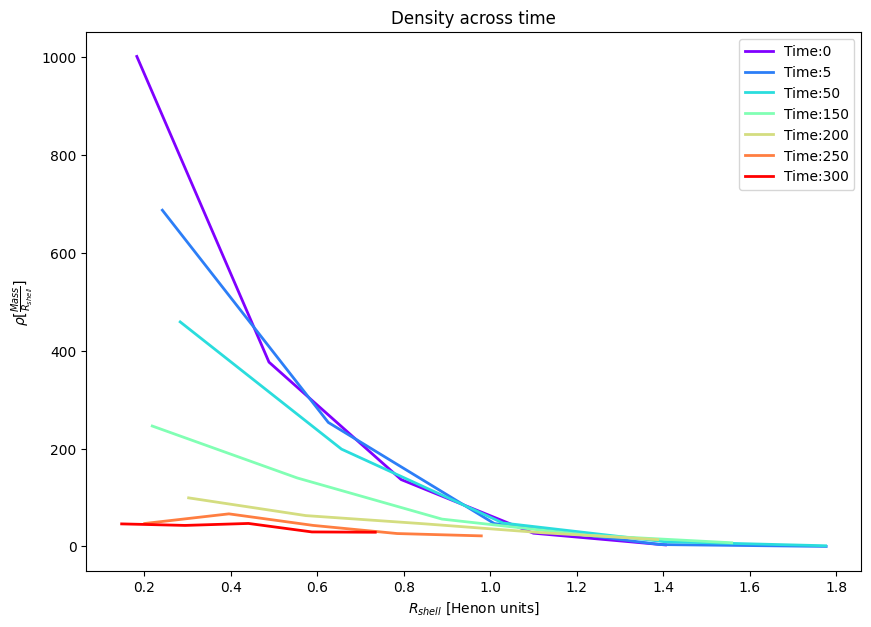

In [8]:
n_bins=5

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
time_to_plot = np.arange(1, len(position), int(len(position)/10) )
time_to_plot = [0, 5, 50, 150, 200, 250, 300]
color = cm.rainbow(np.linspace(0, 1, len(time_to_plot)))

for k, c in enumerate(color):
    time = time_to_plot[k]
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=n_bins)
    Vol_shell = 4/3 *np.pi* (bin_edges[1:]**3 - bin_edges[:-1]**3)
    density = counts / Vol_shell
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.plot(radius_shell, density, color=c, label=f'Time:{time}', linewidth=2)
    ax.set_xlabel(r'$R_{shell}$ [Henon units]')
    ax.set_ylabel(r'$\rho [\frac{Mass}{R_{shell}}]$ ')
    ax.legend(loc='upper right', fontsize=10)
    ax.set_title(f'Density across time')

### Kinematics  with velocity dispersion in shell and cumulative till the half mass radius

#### Bin the radius into shell, for each shell count the velocioty dispersion of the modulus of the velocity - the modulus of the velocity of the CoM

/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


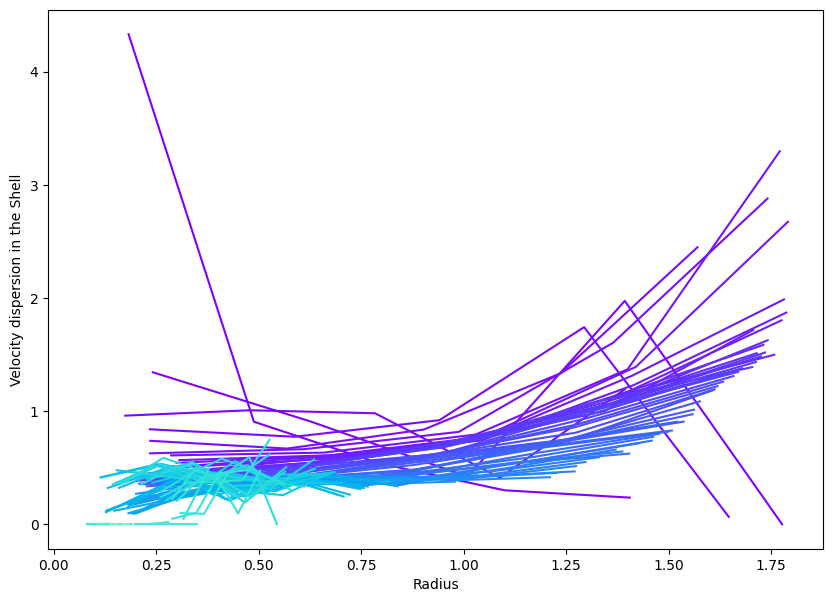

In [9]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
time_to_plot = np.arange(0, len(position_comFoR), 5)
color = cm.rainbow(np.linspace(0, 1, len(time_to_plot)))
n_bins=5

for k, c in enumerate(color):
    time = time_to_plot[k]
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=n_bins)
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1]) #needed to plot
    
    bins_index = np.digitize(radius_snapshot, bins=bin_edges) #return the index of the bin for each radius
    
    vel_snapshot = velocity[time][flag_history[time]]-np.linalg.norm(vel_com_history[time]) #- vel_com_history[time]
    vel_modul_snapshot = np.linalg.norm(vel_snapshot, axis=1)
    
    vel_modul_snaphost_binned = [vel_modul_snapshot[bins_index==i].tolist() for i in range(1, len(bin_edges)) ] #binning the velocity as the radius
    
    velocity_dispersion = []
    for i in range(len(bin_edges)-1):
        velocity_dispersion.append(np.array(vel_modul_snaphost_binned[i]).std())
    
    ax.plot(radius_shell, np.array(velocity_dispersion), label=f'Time: {time}', color=c)
    ax.set_xlabel('Radius')
    ax.set_ylabel('Velocity dispersion in the Shell')
    # ax.legend()

#### take only the velocity dispersion in the tangenzial direction, minus the velocity of the CoM

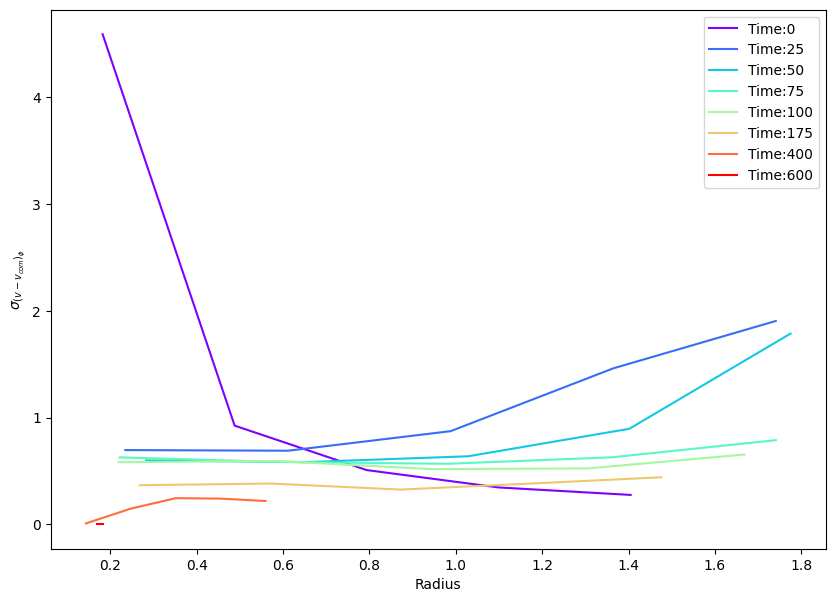

In [10]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
n_bins=5
# time_to_plot = np.arange(0, len(position_comFoR), 5)
time_to_plot = [0, 25, 50, 75,  100, 175, 400, 600]
color = cm.rainbow(np.linspace(0, 1, len(time_to_plot)))


for k, c in enumerate(color):
    time = time_to_plot[k]
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=n_bins)
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1]) #needed to plot
    
    bins_index = np.digitize(radius_snapshot, bins=bin_edges) #return the index of the bin for each radius
    
    vel_wrt_com = velocity[time][flag_history[time]]- vel_com_history[time] #- vel_com_history[time]
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time][flag_history[time]], vel_wrt_com[:, :])

    
    vel_phi_binned = [vel_phi[bins_index==i].tolist() for i in range(1, len(bin_edges)) ] #binning the velocity as the radius
    
    velocity_dispersion = []
    for i in range(len(bin_edges)-1):
        velocity_dispersion.append(np.array(vel_phi_binned[i]).std())
    
    ax.plot(radius_shell, velocity_dispersion, c=c, label=f'Time:{time}')
    ax.set_xlabel('Radius')
    ax.set_ylabel(r'$\sigma_{{(v - v_{com})}_\phi}$')
    ax.legend()

#### take only the velocity dispersion in the radial direction, minus the velocity of the CoM

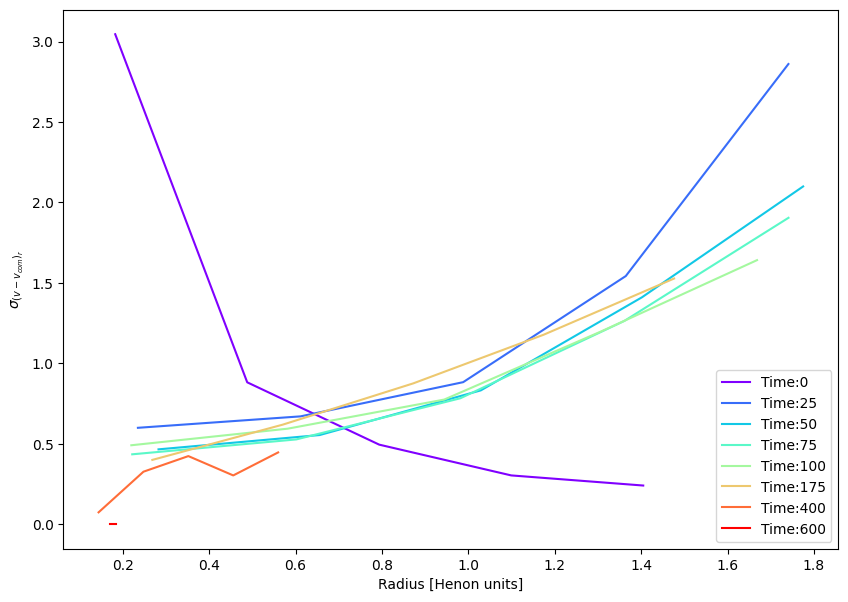

In [11]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
n_bins=5
# time_to_plot = np.arange(0, len(position_comFoR), 5)
time_to_plot = [0, 25, 50, 75,  100, 175, 400, 600]
color = cm.rainbow(np.linspace(0, 1, len(time_to_plot)))


for k, c in enumerate(color):
    time = time_to_plot[k]
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=n_bins)
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1]) #needed to plot
    
    bins_index = np.digitize(radius_snapshot, bins=bin_edges) #return the index of the bin for each radius
    
    vel_wrt_com = velocity[time][flag_history[time]]- vel_com_history[time] #- vel_com_history[time]
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time][flag_history[time]], vel_wrt_com[:, :])

    
    vel_phi_binned = [vel_r[bins_index==i].tolist() for i in range(1, len(bin_edges)) ] #binning the velocity as the radius
    
    velocity_dispersion = []
    for i in range(len(bin_edges)-1):
        velocity_dispersion.append(np.array(vel_phi_binned[i]).std())
    
    ax.plot(radius_shell, velocity_dispersion, c=c, label=f'Time:{time}')
    ax.set_xlabel('Radius [Henon units]')
    ax.set_ylabel(r'$\sigma_{{(v - v_{com})}_r}$')
    ax.legend()

#### take only the velocity dispersion in the z direction, minus the velocity of the CoM

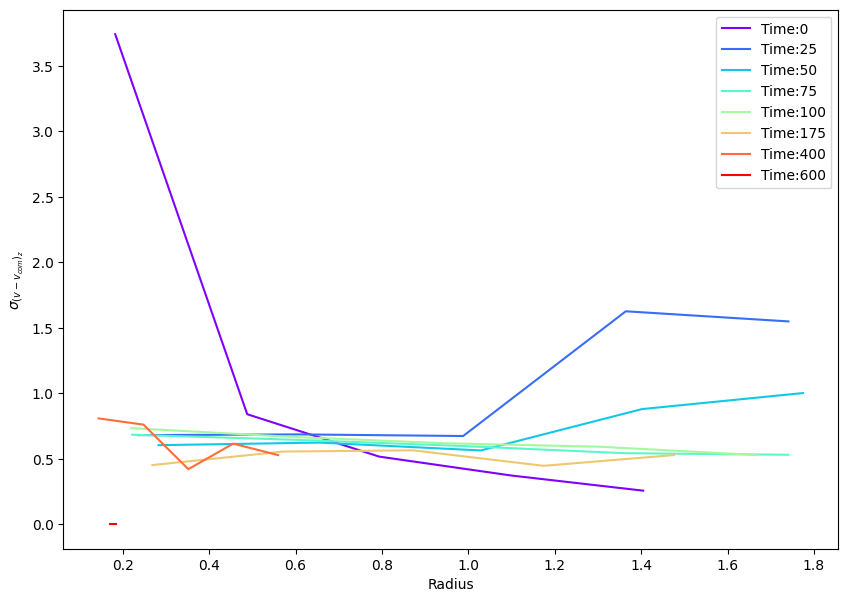

In [12]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
n_bins=5
# time_to_plot = np.arange(0, len(position_comFoR), 5)
time_to_plot = [0, 25, 50, 75,  100, 175, 400, 600]
color = cm.rainbow(np.linspace(0, 1, len(time_to_plot)))


for k, c in enumerate(color):
    time = time_to_plot[k]
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=n_bins)
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1]) #needed to plot
    
    bins_index = np.digitize(radius_snapshot, bins=bin_edges) #return the index of the bin for each radius
    
    vel_wrt_com = velocity[time][flag_history[time]]- vel_com_history[time] #- vel_com_history[time]
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time][flag_history[time]], vel_wrt_com[:, :])

    
    vel_phi_binned = [vel_z[bins_index==i].tolist() for i in range(1, len(bin_edges)) ] #binning the velocity as the radius
    
    velocity_dispersion = []
    for i in range(len(bin_edges)-1):
        velocity_dispersion.append(np.array(vel_phi_binned[i]).std())
    
    ax.plot(radius_shell, velocity_dispersion, c=c, label=f'Time:{time}')
    ax.set_xlabel('Radius')
    ax.set_ylabel(r'$\sigma_{{(v - v_{com})}_z}$')
    ax.legend()

#### velocity dispersion of the velocity modulus inside the r_h

Text(0, 0.5, '$\\sigma_{|v|-|v_{com}|}$ [Henon Unit]')

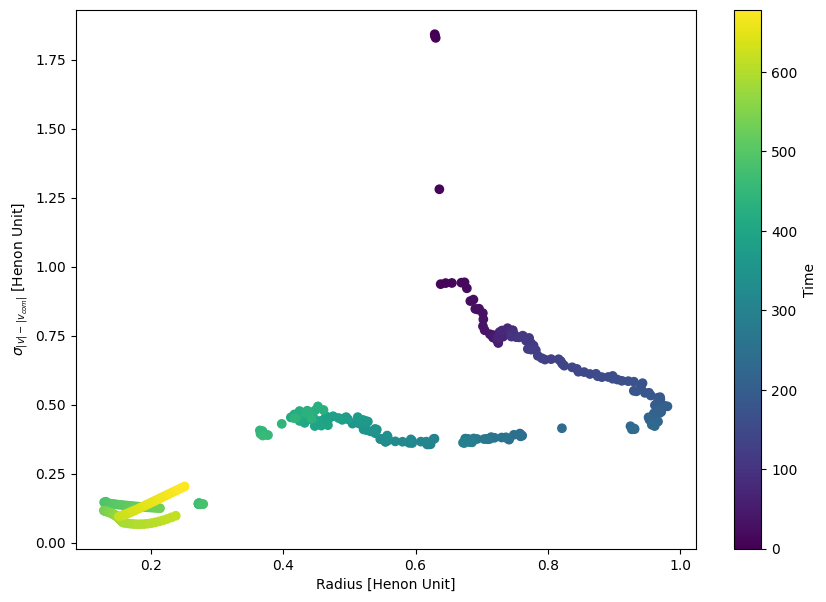

In [13]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
time_to_plot = np.arange(0, len(position_comFoR), 2)
n_bins=10

velocity_dispersion_half_mass_radius = []
half_mass_radius_list = []
time_list = []

for k, time in enumerate(time_to_plot):
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    if np.sort(radius_snapshot).shape[0]<1:
        break
    half_mass_radius = np.sort(radius_snapshot)[int(len(radius_snapshot)/2)]
    
    vel_snapshot = velocity[time][flag_history[time]]-np.linalg.norm(vel_com_history[time]) #- vel_com_history[time]
    vel_modul_snapshot = np.linalg.norm(vel_snapshot, axis=1)
    
    vel_half_mass_radius =  vel_modul_snapshot[np.argsort(radius_snapshot)]
    vel_half_mass_radius =  vel_half_mass_radius[:int(len(vel_half_mass_radius/2))]
    std_half_mass_radius = vel_half_mass_radius.std()
    velocity_dispersion_half_mass_radius.append(std_half_mass_radius)
    half_mass_radius_list.append(half_mass_radius)
    time_list.append(time)
    
pcm = ax.scatter(half_mass_radius_list, velocity_dispersion_half_mass_radius, label=f'Time: {time}', c=time_list)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Time')
ax.set_xlabel('Radius [Henon Unit]')
ax.set_ylabel(r'$\sigma_{|v|-|v_{com}|}$ [Henon Unit]')

#### velocity dispersion of the tangential velocity  inside the r_h

Text(0, 0.5, '$\\sigma_{{(v - v_{com})}_{\\phi, r<r_{half}}}$ [Henon Unit]')

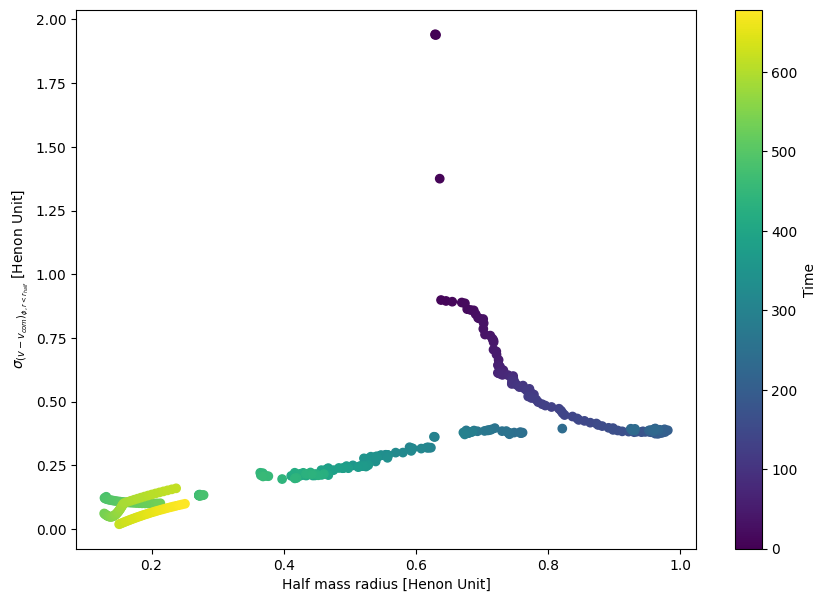

In [14]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
time_to_plot = np.arange(0, len(position_comFoR), 2)
n_bins=10

velocity_dispersion_half_mass_radius = []
half_mass_radius_list = []
time_list = []

for k, time in enumerate(time_to_plot):
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    if np.sort(radius_snapshot).shape[0]<1:
        break
    half_mass_radius = np.sort(radius_snapshot)[int(len(radius_snapshot)/2)]
    
    vel_wrt_com = velocity[time][flag_history[time]]- vel_com_history[time] #- vel_com_history[time]
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time][flag_history[time]], vel_wrt_com[:, :])
    
    vel_half_mass_radius =  vel_phi[np.argsort(radius_snapshot)]
    vel_half_mass_radius =  vel_half_mass_radius[:int(len(vel_half_mass_radius/2))]
    std_half_mass_radius = vel_half_mass_radius.std()
    velocity_dispersion_half_mass_radius.append(std_half_mass_radius)
    half_mass_radius_list.append(half_mass_radius)
    time_list.append(time)
    
pcm = ax.scatter(half_mass_radius_list, velocity_dispersion_half_mass_radius, label=f'Time: {time}', c=time_list)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Time')
ax.set_xlabel('Half mass radius [Henon Unit]')
ax.set_ylabel(r'$\sigma_{{(v - v_{com})}_{\phi, r<r_{half}}}$ [Henon Unit]')

Text(0, 0.5, '$\\sigma_{{(v - v_{com})}_{\\phi, r<r_{half}}}$ [Henon Unit]')

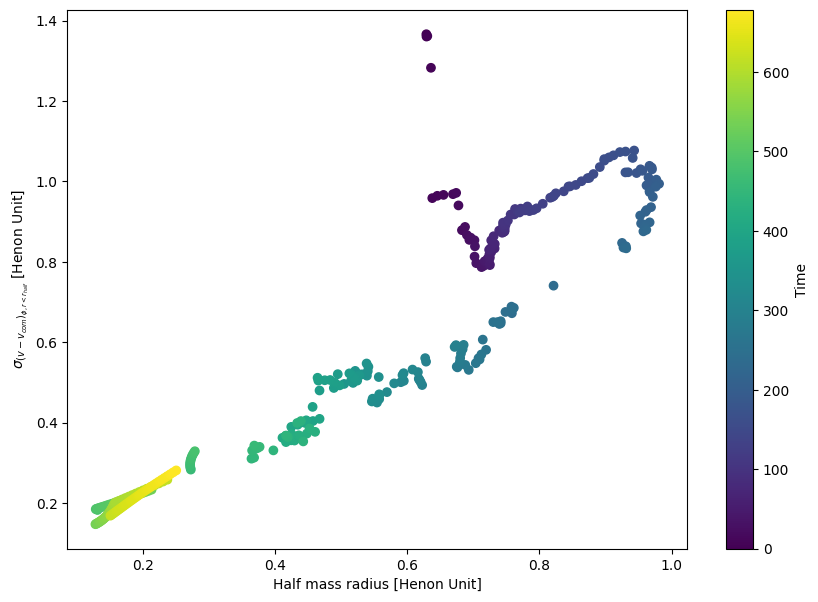

In [15]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
time_to_plot = np.arange(0, len(position_comFoR), 2)
n_bins=10

velocity_dispersion_half_mass_radius = []
half_mass_radius_list = []
time_list = []

for k, time in enumerate(time_to_plot):
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    if np.sort(radius_snapshot).shape[0]<1:
        break
    half_mass_radius = np.sort(radius_snapshot)[int(len(radius_snapshot)/2)]
    
    vel_wrt_com = velocity[time][flag_history[time]]- vel_com_history[time] #- vel_com_history[time]
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time][flag_history[time]], vel_wrt_com[:, :])
    
    vel_half_mass_radius =  vel_r[np.argsort(radius_snapshot)]
    vel_half_mass_radius =  vel_half_mass_radius[:int(len(vel_half_mass_radius/2))]
    std_half_mass_radius = vel_half_mass_radius.std()
    velocity_dispersion_half_mass_radius.append(std_half_mass_radius)
    half_mass_radius_list.append(half_mass_radius)
    time_list.append(time)
    
pcm = ax.scatter(half_mass_radius_list, velocity_dispersion_half_mass_radius, label=f'Time: {time}', c=time_list)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Time')
ax.set_xlabel('Half mass radius [Henon Unit]')
ax.set_ylabel(r'$\sigma_{{(v - v_{com})}_{\phi, r<r_{half}}}$ [Henon Unit]')

## Mass loss

Text(0, 0.5, 'Cum Mass Loss')

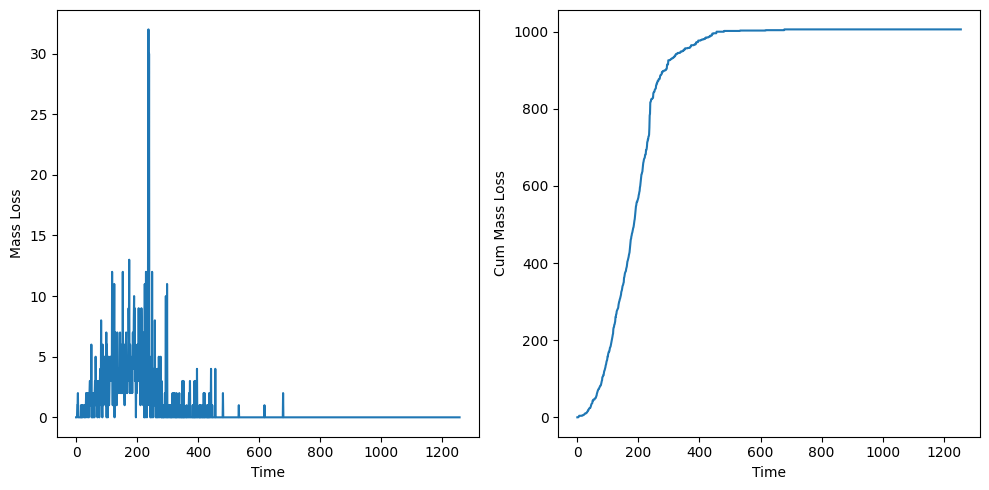

In [16]:
flag_history = np.array(flag_history)
mass_loss = abs(flag_history[1:, :].sum(axis=1) - flag_history[:-1, :].sum(axis=1))
mass_loss_cum = np.cumsum(mass_loss)

fig = plt.figure(figsize=(10, 5), layout='tight')
ax = fig.add_subplot(121)
ax.plot( mass_loss)
ax.set_xlabel('Time')
ax.set_ylabel('Mass Loss')
ax = fig.add_subplot(122)
ax.plot(mass_loss_cum)
ax.set_xlabel('Time')
ax.set_ylabel('Cum Mass Loss')

## Tidal Radius

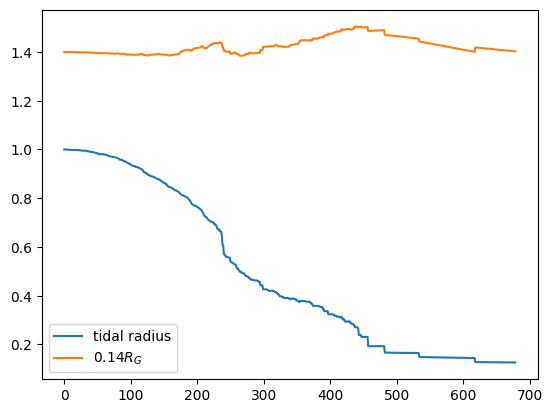

In [17]:
plt.plot(tidal2_history, label='tidal radius')
plt.plot(0.14*np.linalg.norm(com_history, axis=1), label=r'0.14$R_G$')
plt.legend()

# Orbit of the two center of mass (true vs iterative) 

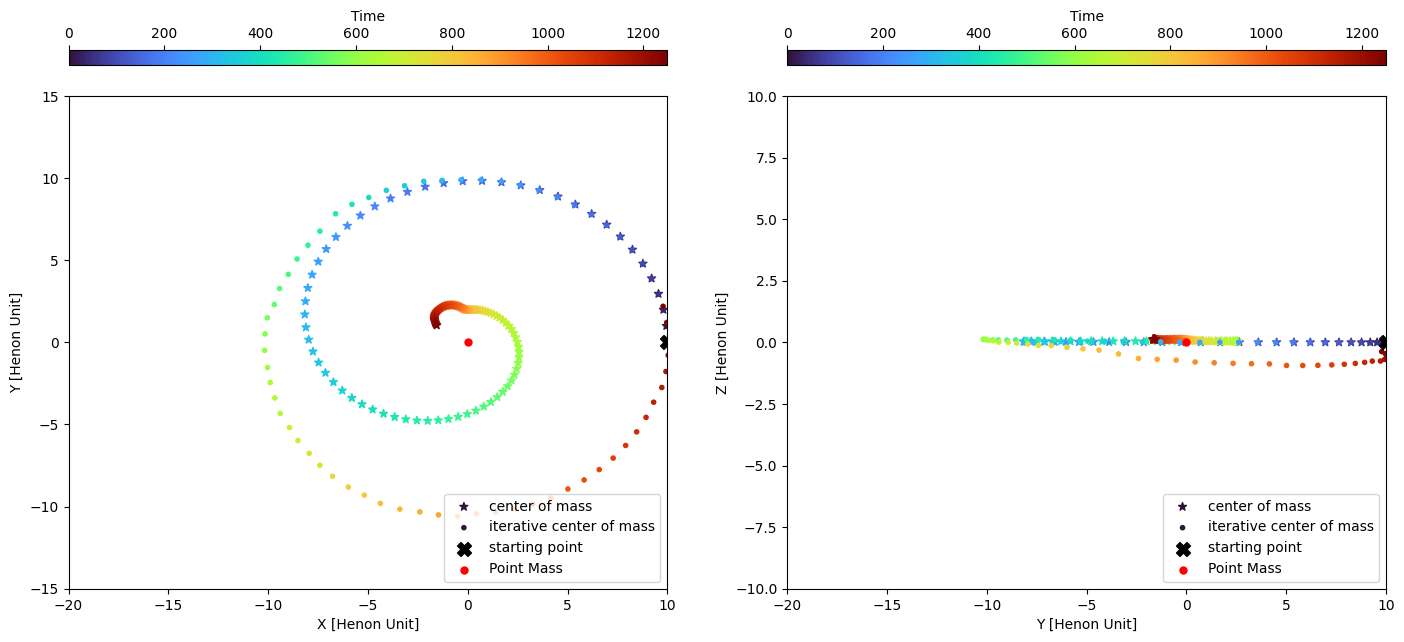

In [18]:
m = 10
cmap = plt.colormaps['turbo']
cmap2 = plt.colormaps['viridis']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), m)

fig = plt.figure(figsize=(17, 8))
ax = fig.add_subplot(121)
pcm = ax.scatter(position[::m, :, 0].mean(axis=1), position[::m, :, 1].mean(axis=1), c=step,  marker='*', label='center of mass', cmap=cmap)
ax.scatter(com_history[::m, 0], com_history[::m, 1], c=step, marker='.', label='iterative center of mass', cmap=cmap)
ax.scatter(position[0, :, 0].mean(), position[0, :, 1].mean(), marker='X', s=100, label='starting point', color='black')
ax.scatter(0, 0, marker='.', s=100, label='Point Mass', color='red')
cbar = fig.colorbar(pcm, ax=ax, location='top', aspect=40)
cbar.set_label(r'Time')
ax.set_xlim(-semi_major_axis-initial_position, semi_major_axis)
ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)
ax.set_xlabel('X [Henon Unit]')
ax.set_ylabel('Y [Henon Unit]')
ax.legend(loc='lower right')

ax2 = fig.add_subplot(122)
pcm=ax2.scatter(position[::m, :, 0].mean(axis=1), position[::m, :, 2].mean(axis=1), c=step,  marker='*', label='center of mass', cmap=cmap)
ax2.scatter(com_history[::m, 0], com_history[::m, 2], c=step, marker='.', label='iterative center of mass', cmap=cmap)
ax2.scatter(position[0, :, 0].mean(), position[0, :, 2].mean(), marker='X', s=100, label='starting point', color='black')
cbar = fig.colorbar(pcm, ax=ax2, location='top', aspect=40)
cbar.set_label(r'Time')
ax2.scatter(0, 0, marker='.', s=100, label='Point Mass', color='red')
ax2.set_xlabel('Y [Henon Unit]')
ax2.set_ylabel('Z [Henon Unit]')
ax2.set_xlim(-semi_major_axis-initial_position, semi_major_axis)
ax2.set_ylim(-semi_major_axis, semi_major_axis)
ax2.legend(loc='lower right')

# Projection on two planes (X vs Y) and (X vs Z)

## Projection on all the particles

In [ ]:
important_time = np.linspace(0, len(position)-1, 6, dtype=int)
important_time


In [ ]:
cmap = plt.colormaps['magma']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)


for k, time in enumerate(important_time): 
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)


    if k>0:
        ax.scatter(position[important_time[k-1], :, 0], position[important_time[k-1], :, 1],  marker='.', color='black', alpha=0.5, label=f'Time={important_time[k-1]}')
        ax.scatter(com_history[important_time[k-1], 0], com_history[important_time[k-1], 1],  marker='*', color='red', alpha=0.5, label=f'iterative CoM Time={important_time[k-1]}')
        ax2.scatter(position[important_time[k-1], :, 0], position[important_time[k-1], :, 2],  marker='.', color='black', alpha=0.5, label=f'Time={important_time[k-1]}')
        ax2.scatter(com_history[important_time[k-1], 0], com_history[important_time[k-1], 2],  marker='*', color='red', alpha=0.5, label=f'iterative CoM Time={important_time[k-1]}')
        # ax.set_xlim(-semi_major_axis-5, semi_major_axis+1)
        # ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)

    ax.scatter(position[time, :, 0], position[time, :, 1],  marker='.', label=f'Time={time}')
    ax.scatter(com_history[time, 0], com_history[time, 1],  marker='*', label=f'iterative CoM Time={time}')
    ax.scatter(0,0)
    ax.set_xlabel('X [Henon Unit]')
    ax.set_ylabel('Y [Henon Unit]')
    # ax.legend()

        
    ax2.scatter(position[time, :, 0], position[time, :, 2],  marker='.', label=f'Time={time}')
    ax2.scatter(com_history[time, 0], com_history[time, 2],  marker='*', label=f'iterative CoM Time={time}')
    ax2.set_xlabel('X [Henon Unit]')
    ax2.set_ylabel('Z [Henon Unit]')
    ax2.legend()

## Projection on all the flag

In [ ]:
cmap = plt.colormaps['magma']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)


for k, time in enumerate(important_time): 
    flag = flag_history[time]
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)


    if k>0:
        ax.scatter(0,0, color='green', label='Point Mass')
        ax.scatter(position[important_time[k-1], :, 0][flag_history[important_time[k-1]]], position[important_time[k-1], :, 1][flag_history[important_time[k-1]]],  marker='.', color='black', alpha=0.5, label=f'Time={important_time[k-1]}')
        ax.scatter(com_history[important_time[k-1], 0], com_history[important_time[k-1], 1],  marker='X', color='red', alpha=0.5, label=f'iterative CoM Time={important_time[k-1]}')
        ax2.scatter(position[important_time[k-1], :, 0][flag_history[important_time[k-1]]], position[important_time[k-1], :, 2][flag_history[important_time[k-1]]],  marker='.', color='black', alpha=0.5, label=f'Time={important_time[k-1]}')
        ax2.scatter(com_history[important_time[k-1], 0], com_history[important_time[k-1], 2],  marker='X', color='red', alpha=0.5, label=f'iterative CoM Time={important_time[k-1]}')
        ax.set_xlim(-semi_major_axis-5, semi_major_axis+1)
        ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)
        # ax.grid()
        
    ax.scatter(position[time, :, 0][flag], position[time, :, 1][flag],  marker='.', label=f'Time={time}')
    ax.scatter(com_history[time, 0], com_history[time, 1],  marker='*', label=f'iterative CoM Time={time}')
    ax.set_xlabel('X [Henon Unit]')
    ax.set_ylabel('Y [Henon Unit]')
    ax.legend()

        
    ax2.scatter(position[time, :, 0][flag], position[time, :, 2][flag],  marker='.', label=f'Time={time}')
    ax2.scatter(com_history[time, 0], com_history[time, 2],  marker='*', label=f'iterative CoM Time={time}')
    ax2.set_xlabel('X [Henon Unit]')
    ax2.set_ylabel('Z [Henon Unit]')
    ax2.set_xlim(-initial_position-1, initial_position+1)
    ax2.set_ylim(-initial_position-1, initial_position+1)
    ax2.legend()

## Projection on all the non flag (the stream)

In [ ]:
cmap = plt.colormaps['magma']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)


for k, time in enumerate(important_time): 
    flag = flag_history[time]
    no_flag = ~flag
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)


    if k>0:
        ax.scatter(position[important_time[k-1], :, 0][no_flag], position[important_time[k-1], :, 1][no_flag],  marker='.', color='black', alpha=0.5, label=f'Time={important_time[k-1]}')
        ax.scatter(com_history[important_time[k-1], 0], com_history[important_time[k-1], 1],  marker='X', color='red', alpha=0.5, label=f'iterative CoM Time={important_time[k-1]}')
        ax2.scatter(position[important_time[k-1], :, 0][no_flag], position[important_time[k-1], :, 2][no_flag],  marker='.', color='black', alpha=0.5, label=f'Time={important_time[k-1]}')
        ax2.scatter(com_history[important_time[k-1], 0], com_history[important_time[k-1], 2],  marker='X', color='red', alpha=0.5, label=f'iterative CoM Time={important_time[k-1]}')
        ax.set_xlim(-semi_major_axis-5, semi_major_axis+1)
        ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)
        ax2.set_xlim(-initial_position-1, initial_position+1)
        ax2.set_ylim(-initial_position-5, initial_position+5)

    ax.scatter(position[time, :, 0][no_flag], position[time, :, 1][no_flag],  marker='.', label=f'Time={time}')
    ax.scatter(com_history[time, 0], com_history[time, 1],  marker='*', label=f'iterative CoM Time={time}')
    ax.set_xlabel('X [Henon Unit]')
    ax.set_ylabel('Y [Henon Unit]')
    ax.legend()
    circle = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='r', fill=False, label=r'R< $2r_t$')

    ax.add_patch(circle)

        
    ax2.scatter(position[time, :, 0][no_flag], position[time, :, 2][no_flag],  marker='.', label=f'Time={time}')
    ax2.scatter(com_history[time, 0], com_history[time, 2],  marker='*', label=f'iterative CoM Time={time}')
    ax2.set_xlabel('X [Henon Unit]')
    ax2.set_ylabel('Z [Henon Unit]')
    ax2.legend()

# Tidal stream: Rotation on CoM position and polar coordinates, test with DBSCAN

In [ ]:
fig=plt.figure(figsize=(15, 7), layout='tight')
for i, time in enumerate(important_time[1:]):
    com = com_history[time]
    flag=flag_history[time]
    no_flag=~flag
    X = np.stack((position[time, :, 0][no_flag], position[time, :, 1][no_flag], np.zeros_like(position[time, :, 1][no_flag])), axis=1)
    avg_distance = np.linalg.norm((position[time][flag]-com_history[time]), axis=1).mean()
    
    clustering = DBSCAN(eps=avg_distance, min_samples=2).fit(X)
    cluster = clustering.fit_predict(X)
    name_cluster, num_part = np.unique(cluster, return_counts=True)
    cluster[cluster!=name_cluster[np.argmax(num_part)]] = name_cluster[np.argmin(num_part)]
    
    r_com, theta_com, phi_com = cartesian2spherical([com[0], com[1], com[2]], out_type='rad')
    c, s = np.cos(phi_com), np.sin(phi_com)
    R = np.array(((c, -s), (s, c)))
    X[:, :2] = np.dot(X[:, :2], R)
    r, phi, theta = cartesian2spherical([X[:, 0], X[:, 1], X[:, 2]], out_type='rad')
    ax = fig.add_subplot(2, 4, i+1)
    ax.scatter(r-r_com, theta, c=cluster, s=1)
    ax.set_xlim(-10, 10)
    ax.set_title(f'Time:{time}, fraction in main cluster:{num_part.max()/len(X):.2f}')
    ax.set_xlabel(r'R-R_com')
    ax.set_ylabel(r'$\theta$')
    

In [ ]:
important_time = [0, 150, 250]

In [ ]:
fig=plt.figure(figsize=(15, 7), layout='tight')
for i, time in enumerate(important_time[1:]):
    com = com_history[time]
    flag=flag_history[time]
    no_flag=~flag
    X = np.stack((position[time, :, 0][no_flag], position[time, :, 1][no_flag], np.zeros_like(position[time, :, 1][no_flag])), axis=1)
    avg_distance = np.linalg.norm((position[time][flag]-com_history[time]), axis=1).mean()
    
    clustering = DBSCAN(eps=avg_distance, min_samples=2).fit(X)
    cluster = clustering.fit_predict(X)
    name_cluster, num_part = np.unique(cluster, return_counts=True)
    cluster[cluster!=name_cluster[np.argmax(num_part)]] = name_cluster[np.argmin(num_part)]
    
    r_com, theta_com, phi_com = cartesian2spherical([com[0], com[1], com[2]], out_type='rad')
    c, s = np.cos(phi_com), np.sin(phi_com)
    R = np.array(((c, -s), (s, c)))
    X[:, :2] = np.dot(X[:, :2], R)
    r, phi, theta = cartesian2spherical([X[:, 0], X[:, 1], X[:, 2]], out_type='rad')
    ax = fig.add_subplot(2, 4, i+1)
    ax.scatter(r-r_com, theta, c=cluster, s=1)
    ax.set_xlim(-10, 10)
    ax.set_title(f'Time:{time}, fraction in main cluster:{num_part.max()/len(X):.2f}')
    ax.set_xlabel(r'R-R_com')
    ax.set_ylabel(r'$\theta$')

## Spline to get the length of the tidal structure 

In [ ]:
fig=plt.figure(figsize=(15, 7), layout='tight')
for i, time in enumerate(important_time[1:]):
    flag=flag_history[time]
    no_flag=~flag
    X = np.stack((position[time, :, 0][no_flag], position[time, :, 1][no_flag], np.zeros_like(position[time, :, 1][no_flag])), axis=1)
    avg_distance = np.linalg.norm((position[time][flag]-com_history[time]), axis=1).mean()
    
    clustering = DBSCAN(eps=avg_distance, min_samples=2).fit(X)
    cluster = clustering.fit_predict(X)
    name_cluster, num_part = np.unique(cluster, return_counts=True)
    max = name_cluster[np.argmax(num_part)]
    min = np.argmin(num_part)
    cluster[cluster!=max] = min

    #spline interpolation of dense point
    x = sorted(X[:, 0][cluster==max])/np.max(abs(X[:, 0][cluster==max]))
    y = X[:, 1][cluster==max][np.argsort(X[:, 0][cluster==max])]/np.max(abs(X[:, 1][cluster==max]))
    (tck, u) = splprep([x, y], k=3) #s = optional parameter (default used here)
    x_new, y_new = splev(u, tck)
    x_new *=np.max(abs(X[:, 0][cluster==max]))
    y_new *=np.max(abs(X[:, 1][cluster==max]))
    

    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(sorted(x_new), y_new[np.argsort(x_new)], linewidth=1, c='r', label='spline')
    ax.scatter(X[:, 0], X[:, 1], c=cluster, s=1)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-10, 20)
    ax.set_title(f'Time:{time}, fraction in main cluster:{num_part.max()/len(X):.2f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    

# Density plot on X, Y

In [ ]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
important_time = [0, 50, 75, 150, 250, 400, 4000]
important_time = [0, 100, 1000, 2000, 2500, 2700, 3000, 3500, 4000]

In [ ]:
fig=plt.figure(figsize=(15, 7), layout='tight')
for i, time in enumerate(important_time[1:]):
    flag=flag_history[time]
    no_flag=~flag
    X = np.stack((position[time, :, 0][no_flag], position[time, :, 1][no_flag], np.zeros_like(position[time, :, 1][no_flag])), axis=1)

    xy = np.vstack([X[:,0], X[:,1]])
    z = gaussian_kde(xy)(xy)
    cov = gaussian_kde(xy).covariance
    

    ax = fig.add_subplot(2, 4, i+1)
    pcm = ax.scatter(X[:, 0], X[:, 1], c=z, s=1)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$\rho$')
    # confidence_ellipse(X[:, 0], X[:, 1], ax, n_std=1, edgecolor='red')
    ax.set_title(f'Time: {time}')
    # ax.set_xlim(-semi_major_axis-5, semi_major_axis+5)
    # ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    

## density plot using DBSCAN to reduce dimensionality 

In [ ]:
fig=plt.figure(figsize=(15, 7), layout='tight')
for i, time in enumerate(important_time[1:]):
    flag=flag_history[time]
    no_flag=~flag
    X = np.stack((position[time, :, 0][no_flag], position[time, :, 1][no_flag], np.zeros_like(position[time, :, 1][no_flag])), axis=1)

    avg_distance = np.linalg.norm((position[time][flag]-com_history[time]), axis=1).mean()
    
    clustering = DBSCAN(eps=avg_distance, min_samples=2).fit(X)
    cluster = clustering.fit_predict(X)
    name_cluster, num_part = np.unique(cluster, return_counts=True)
    cluster[cluster!=name_cluster[np.argmax(num_part)]] = name_cluster[np.argmin(num_part)]

    
    x = X[:, 0][cluster==max]
    y = X[:, 1][cluster==max]

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    cov = gaussian_kde(xy).covariance

    ax = fig.add_subplot(2, 4, i+1)
    ax.scatter(x, y, c=z, s=1)
    confidence_ellipse(x, y, ax, n_std=1, edgecolor='red')
    ax.set_xlim(-20, 20)
    ax.set_ylim(-10, 20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'time:{time}')
    

# Drift of the stars according to their velocity

In [ ]:
important_time = [100, 150, 175, 190, 200, 225, 250, 275]

In [ ]:
cmap = plt.colormaps['turbo']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)

fig = plt.figure(layout='tight', figsize=(20,10))
for k, time in enumerate(important_time[1:]): 
    circle = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='r', fill=False, label=r'R< $2r_t$')

    # vel_rho, vel_phi = cyl_coord(velocity[time, :, :])
    # vel_rho_com, vel_phi_com = cyl_coord(vel_com_history[time])  

    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time, :, :], velocity[time, :, :])
    rho_com, phi_com, vel_r_com, vel_phi_com, vel_z_com = cyl_coord(com_history[time], vel_com_history[time])
    vel_wrt_com = vel_phi - vel_phi_com
    ax = fig.add_subplot(2, 4, k+1)

    ax.scatter(0,0, label='Point Mass')
    pcm = ax.scatter(position[time, :, 0], position[time, :, 1], s=1, c=vel_wrt_com/vel_wrt_com.max(),  marker='.', cmap=cmap)
    ax.scatter(com_history[time][0], com_history[time][1], marker='*', color='red')
    ax.add_patch(circle)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$\frac{v_\phi - v_{\phi, com}}{v_{\phi,max}}$')
    # pcm.set_clim(vmin=-1.0, vmax=1.0)
    
    ax.set_xlabel('X [Henon Unit]')
    ax.set_ylabel('Y [Henon Unit]')
    ax.set_xlim(-semi_major_axis-20, semi_major_axis+20)
    ax.set_ylim(-semi_major_axis-20, semi_major_axis+20)
    ax.set_title(f'Time:{time}')
    ax.legend()
    fig.show()

In [ ]:
cmap = plt.colormaps['magma']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)

fig = plt.figure(layout='tight', figsize=(20,10))
for k, time in enumerate(important_time[1:]): 
    circle = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='r', fill=False, label=r'R< $2r_t$')
    
    vel_wrt_com = np.linalg.norm(velocity[time, :, :], axis=1)**2 - np.linalg.norm(vel_com_history[time])**2
    ax = fig.add_subplot(2, 4, k+1)

    pcm = ax.scatter(position[time, :, 0], position[time, :, 1], s=1, c=vel_wrt_com,  marker='.', )
    ax.scatter(com_history[time][0], com_history[time][1], marker='*', color='red')
    ax.add_patch(circle)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$|v|^2 - |v_{com}|^2$')
    ax.set_xlabel('X [Henon Unit]')
    ax.set_ylabel('Y [Henon Unit]')
    # ax.set_xlim(-initial_position-1, initial_position+1)
    # ax.set_ylim(-initial_position-5, initial_position+5)
    ax.set_title(f'Time:{time}')
    ax.legend()
    fig.show()

## moved to the frame of reference of the CoM

In [ ]:
cmap = plt.colormaps['turbo']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)

fig = plt.figure(layout='tight', figsize=(20,10))
for k, time in enumerate(important_time[1:]): 
    circle = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='r', fill=False, label=r'R< $2r_t$')
    
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time, :, :], velocity[time, :, :])
    rho_com, phi_com, vel_r_com, vel_phi_com, vel_z_com = cyl_coord(com_history[time], vel_com_history[time])  
    vel_phi_wrt_com = vel_phi - vel_phi_com
    vel_rho_wrt_com = vel_r - vel_r_com
    E_kin = np.linalg.norm(velocity[time, :, :], axis=1)**2
    E_pot = potential_energy[time]
    E_tot = E_kin + E_pot
    ax = fig.add_subplot(2, 4, k+1)

    pcm = ax.scatter(position[time, :, 0], position[time, :, 1], s=1, c=vel_phi_wrt_com/vel_phi_wrt_com.max(),  marker='.', cmap=cmap)
    # pcm = ax.scatter(position[time, :, 0][np.linalg.norm(position[time, :, :], axis=1) < 20], position[time, :, 1][np.linalg.norm(position[time, :, :], axis=1) < 20], s=1, c=E_tot[np.linalg.norm(position[time, :, :], axis=1) < 20],  marker='.', cmap=cmap)

    ax.scatter(com_history[time][0], com_history[time][1], marker='*', color='red')
    ax.scatter(0,0, marker='*', color='red')
    ax.add_patch(circle)
    
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$E_{tot}$')
    
    ax.set_xlabel('X [Henon Unit]')
    ax.set_ylabel('Y [Henon Unit]')
    ax.set_xlim(com_history[time][0]-10,  com_history[time][0]+10)
    ax.set_ylim(com_history[time][1]-10,  com_history[time][1]+10)
    ax.set_title(f'Time:{time}, vel_phi_com:{vel_phi_com:.2f}')
    ax.legend()
    fig.show()

In [ ]:
cmap = plt.colormaps['turbo']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)

fig = plt.figure(layout='tight', figsize=(20,10))
for k, time in enumerate(important_time[1:]): 
    circle = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='r', fill=False, label=r'R< $2r_t$')
    
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time, :, :], velocity[time, :, :])
    rho_com, phi_com, vel_r_com, vel_phi_com, vel_z_com = cyl_coord(com_history[time], vel_com_history[time])  
    vel_phi_wrt_com = vel_phi - vel_phi_com
    vel_rho_wrt_com = vel_r - vel_r_com
    E_kin = np.linalg.norm(velocity[0, :, :], axis=1)**2
    E_pot = potential_energy[time]
    E_tot = E_kin + E_pot
    ax = fig.add_subplot(2, 4, k+1)

    pcm = ax.scatter(position[time, :, 0], position[time, :, 1], s=1, c=vel_phi_wrt_com/vel_phi_wrt_com.max(),  marker='.', cmap=cmap)
    # pcm = ax.scatter(position[time, :, 0][np.linalg.norm(position[time, :, :], axis=1) < 20], position[time, :, 1][np.linalg.norm(position[time, :, :], axis=1) < 20], s=1, c=E_pot[np.linalg.norm(position[time, :, :], axis=1) < 20],  marker='.', cmap=cmap)

    ax.scatter(com_history[time][0], com_history[time][1], marker='*', color='red')
    ax.scatter(0,0, marker='*', color='red')
    ax.add_patch(circle)
    
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$\frac{v_\phi - v_{\phi, com}}{v_{\phi,max}}$')
    
    ax.set_xlabel('X [Henon Unit]')
    ax.set_ylabel('Y [Henon Unit]')
    ax.set_xlim(com_history[time][0]-10,  com_history[time][0]+10)
    ax.set_ylim(com_history[time][1]-10,  com_history[time][1]+10)
    ax.set_title(f'Time:{time}, vel_phi_com:{vel_phi_com:.2f}')
    ax.legend()
    fig.show()

In [ ]:
#we select the 95% to remove the tail of the velocity distribution which is composed of outliers, NOT USED NOW

fig = plt.figure(layout='tight', figsize=(15,5))
low_quin, high_quin = np.quantile(np.linalg.norm(velocity[time, :, :], axis=1)- np.linalg.norm(vel_com_history[0]), [0.025, 0.975])
# flag = ((np.linalg.norm(velocity[0, :, :], axis=1) - np.linalg.norm(vel_com_history[0]))<low_quin) | ((np.linalg.norm(velocity[0, :, :], axis=1) - np.linalg.norm(vel_com_history[0]))>high_quin)
flag = np.zeros_like(np.linalg.norm(velocity[0, :, :], axis=1), dtype=bool) #no flag to check
for i, time in enumerate(important_time):
    vel_wrt_com = np.linalg.norm(velocity[time, :, :], axis=1)**2 - np.linalg.norm(vel_com_history[time])**2
    pos_wrt_com = np.linalg.norm(position[time], axis=1) - np.linalg.norm(com_history[time])
    ax = fig.add_subplot(2, 4, i+1)
    ax.scatter(pos_wrt_com, vel_wrt_com, s=1, label=f'Time:{time}')
    ax.scatter(pos_wrt_com[flag], vel_wrt_com[flag], s=10)
    ax.set_xlabel(r'$R-R_{com}$')
    ax.set_ylabel(r'$|v|-|v_{com}|$')
    ax.set_title(f'Time:{time}')

In [ ]:
position[time, :, 0].shape

In [ ]:
import matplotlib.tri as tri
fig = plt.figure()
ax1 = fig.add_subplot()

npts = len(position)
ngridx = 100
ngridy = 200

xi = np.linspace(-10, 10, ngridx)
yi = np.linspace(-5, 15, ngridy)
E_kin = np.linalg.norm(velocity[time, :, :], axis=1)**2
E_pot = potential_energy[time]
E_tot = E_kin + E_pot
time=150
triang = tri.Triangulation(position[time, :, 0], position[time, :, 1])
interpolator = tri.LinearTriInterpolator(triang, E_pot)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)


ax1.contour(xi, yi, zi, levels=20, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=20, cmap="magma")

fig.colorbar(cntr1, ax=ax1)
# ax1.plot(position[time, :, 0], position[time, :, 1], 'ko', ms=0.1)
ax1.set_xlim(-10, 10)
ax1.set_ylim(-5, 15)

In [ ]:
fig = plt.figure()
ax2 = fig.add_subplot()


ax2.tricontour(position[time, :, 0], position[time, :, 1], E_pot, levels=5, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(position[time, :, 0], position[time, :, 1], E_pot, levels=14, cmap="turbo")

fig.colorbar(cntr2, ax=ax2)
# ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(-2, 2), ylim=(-2, 2))
ax2.set_title('Fistalloni' )
ax2.set_xlim(-10, 10)
ax2.set_ylim(-5, 15)

## Just the flagged star

In [ ]:
fig = plt.figure(layout='tight', figsize=(15,5))
for i, time in enumerate(important_time):
    vel_wrt_com = np.linalg.norm(velocity[time, :, :], axis=1) - np.linalg.norm(vel_com_history[time])
    pos_wrt_com = np.linalg.norm(position[time], axis=1) - np.linalg.norm(com_history[time])
    ax = fig.add_subplot(2, 5, i+1)
    ax.scatter(pos_wrt_com[~flag], vel_wrt_com[~flag], s=1)
    ax.set_xlabel(r'$R-R_{com}$')
    ax.set_ylabel(r'$|v|-|v_{com}|$')
    ax.set_title(f'Time:{time}')

In [ ]:
fig = plt.figure(layout='tight', figsize=(15,5))
for i, time in enumerate(important_time):
    vel_wrt_com = np.linalg.norm(velocity[time, :, :], axis=1) - np.linalg.norm(vel_com_history[time])
    pos_wrt_com = np.linalg.norm(position[time], axis=1) - np.linalg.norm(com_history[time])
    xy = np.vstack([pos_wrt_com[~flag],vel_wrt_com[~flag]])
    z = gaussian_kde(xy)(xy)
    
    ax = fig.add_subplot(2, 5, i+1)
    pcm = ax.scatter(pos_wrt_com[~flag], vel_wrt_com[~flag],c=z, s=1)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$\rho$')
    ax.plot([-tidal2_history[time], tidal2_history[time]], [0, 0], '--', color='red', label=r'R< $2r_t$')
    ax.set_xlabel(r'$R-R_{com}$')
    ax.set_ylabel(r'$|v|-|v_{com}|$')
    ax.set_title(f'Time:{time}')
    ax.legend()

# Histogram 

In [ ]:
cmap = plt.colormaps['turbo_r']
fig = plt.figure(figsize=(15, 5), layout='tight')
time = 1000
flag=flag_history[time]
no_flag=~flag
X = np.stack((position[time, :, 0][no_flag], position[time, :, 1][no_flag], position[time, :, 2][no_flag]), axis=1)
vel_X = np.stack((velocity[time, :, 0][no_flag], velocity[time, :, 1][no_flag], velocity[time, :, 2][no_flag]), axis=1)
cartesian_X = X.copy()

rho_com, phi_com, vel_r_com, vel_phi_com, vel_z_com = cyl_coord(com_history[time], vel_com_history[time])
rho, phi, vel_r, vel_phi, vel_z = cyl_coord(X, vel_X)
vel_wrt_com = vel_phi - vel_phi_com

plummer_shpere, plummer_shpere_velocity = np.stack((position[time, :, 0][flag], position[time, :, 1][flag], position[time, :, 2][flag]), axis=1), np.stack((velocity[time, :, 0][flag], velocity[time, :, 1][flag], velocity[time, :, 2][flag]), axis=1)
rho_plummer, phi_plummer, vel_r_plummer, vel_phi_plummer, vel_z_plummer = cyl_coord(plummer_shpere, plummer_shpere_velocity)
vel_wrt_com_plummer = vel_phi_plummer - vel_phi_com


ax = fig.add_subplot(1, 2, 1)
ax.scatter(0,0, label='Point Mass', s=50, color='darkgreen',  marker='X')
pcm = ax.scatter(cartesian_X[:, 0], cartesian_X[:, 1],  c=vel_wrt_com/vel_wrt_com.max(),  marker='.', cmap=cmap)
ax.scatter(com_history[time][0], com_history[time][1], marker='*', color='red', label=f'CoM, Time:{time}')
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r'$\frac{v_\phi - v_{\phi, com}}{v_{\phi,max}}$')
pcm.set_clim(vmin=-1.0, vmax=1.0)
ax.set_xlabel('X [Henon Unit]')
ax.set_ylabel('Y [Henon Unit]')
ax.set_xlim(-150, 150)
ax.set_ylim(-100, 200)
ax.legend()


ax = fig.add_subplot(1, 2, 2)
ax.hist(vel_wrt_com[phi-phi_com>0]/vel_wrt_com.max(), bins= 'sqrt', density=True, color='tab:blue', alpha=0.3)
ax.hist(vel_wrt_com[phi-phi_com<0]/vel_wrt_com.max(), bins='sqrt',  density=True, color='tab:red', alpha=0.3)
ax.hist(vel_wrt_com_plummer/vel_wrt_com.max(), bins='sqrt',  density=True, color='lawngreen', alpha=0.3)

density_high = gaussian_kde(vel_wrt_com[phi-phi_com>0]/vel_wrt_com.max())
density_low = gaussian_kde(vel_wrt_com[phi-phi_com<0]/vel_wrt_com.max())
density_plummer = gaussian_kde(vel_wrt_com_plummer/vel_wrt_com.max())
x = np.linspace(vel_wrt_com.min()/vel_wrt_com.max(), vel_wrt_com.max()/vel_wrt_com.max())
ax.plot(x, density_high(x), label=r'$\phi>\phi_{com}$', color='tab:blue')
ax.plot(x, density_low(x), label=r'$\phi<\phi_{com}$', color='tab:red')
ax.plot(x, density_plummer(x), label=r'$r < 2r_t$', color='tab:green')

ax.set_xlabel(r'$\frac{v_\phi - v_{\phi, com}}{v_{\phi,max}}$')
ax.set_ylabel('density')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.legend()
fig.show()